## Call Logs

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sp
import datetime as dt
pd.options.mode.chained_assignment = None 

status_df = pd.read_csv('user_logs/user_status.csv')
status_df['status'] = status_df['status'] == 'repaid'
call_df = pd.read_csv('user_calls.csv')
call_df = call_df.merge(status_df,on="user_id")
call_df['datetime'] = [dt.datetime.fromtimestamp(date_time / 1e3) for date_time in call_df['datetime']]
call_df['hour'] = [date_time.hour for date_time in call_df['datetime']]
call_df['geocoded_location'] = call_df['geocoded_location'].replace(np.nan, 'Kenya', regex=True)
call_df['geocoded_location'] = call_df['geocoded_location'].replace(' ', '', regex=True)
call_df['geocoded_location'] = call_df['geocoded_location'].replace('', 'Kenya', regex=True)
call_df['intl_call'] = call_df['geocoded_location'] != 'Kenya'

# calculate call count, average duration
group_df = call_df.groupby(by=['user_id'])['duration'].agg({'count': len, 'avg_duration': np.mean}) #'total': np.sum
group_df = pd.DataFrame(group_df)
group_df.insert(0, 'user_id', group_df.index)
group_df = group_df.merge(status_df, on=['user_id'])
intl_calls = call_df.groupby(by=['user_id'])['intl_call'].sum().reset_index()
group_df = group_df.merge(intl_calls, on=['user_id'])

In [61]:
# a feature worth considering
print sp.pearsonr(group_df['intl_call'], group_df['status'])

sub1 = group_df[group_df['intl_call']==0]
sub2 = group_df[group_df['intl_call']>0]
print np.mean(sub1['status']), np.mean(sub2['status'])

(0.15258153630188998, 0.002213244134113283)
0.440559440559 0.649122807018


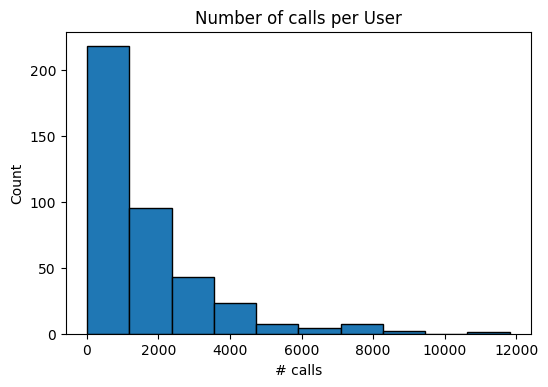

In [2]:
plt.hist(group_df['count'], edgecolor='black')
plt.title('Number of calls per User')
plt.xlabel('# calls')
plt.ylabel('Count')
# plt.savefig('photos/call_count_hist.png')
plt.show()

In [30]:
# to do: check disbursement by day of week (???), call type...
# length of ownership is a bad indicator...
# simultaneous devices

In [32]:
# clear positive association between number of calls and loan status
print sp.pearsonr(group_df['count'], group_df['status'])

# weaker association with average duration; tried total duration but found no added insights
print sp.pearsonr(group_df['avg_duration'], group_df['status'])

(0.49147750318399142, 1.028787562126901e-25)
(0.16426526977387562, 0.00097566977993749336)


In [63]:
sub1 = group_df[group_df['count'] >= 1000]
sub2 = group_df[group_df['count'] < 1000]
sub3 = group_df[group_df['count'] >= 1500]
sub4 = group_df[group_df['count'] < 500]

print 'reimbursement rate (>= 1000 calls):', sum(sub1['status'])/float(len(sub1))
print 'reimbursement rate (< 1000 calls): ', sum(sub2['status'])/float(len(sub2))
print 'reimbursement rate (>= 1500 calls):', sum(sub3['status'])/float(len(sub3))
print 'reimbursement rate (< 500 calls):  ', sum(sub4['status'])/float(len(sub4))

reimbursement rate (>= 1000 calls): 0.740196078431
reimbursement rate (< 1000 calls):  0.25
reimbursement rate (>= 1500 calls): 0.845070422535
reimbursement rate (< 500 calls):   0.229885057471


In [5]:
# visualize distribution of calls across hours 0-23 among each subpopulation (weighting each user equally)
good_df = call_df[call_df['status']]
bad_df = call_df[~call_df['status']]

good_call_counts = good_df.groupby(by=['hour'])['call_type'].count()
good_call_counts /= good_call_counts.sum()
bad_call_counts = bad_df.groupby(by=['hour'])['call_type'].count()
bad_call_counts /= bad_call_counts.sum()

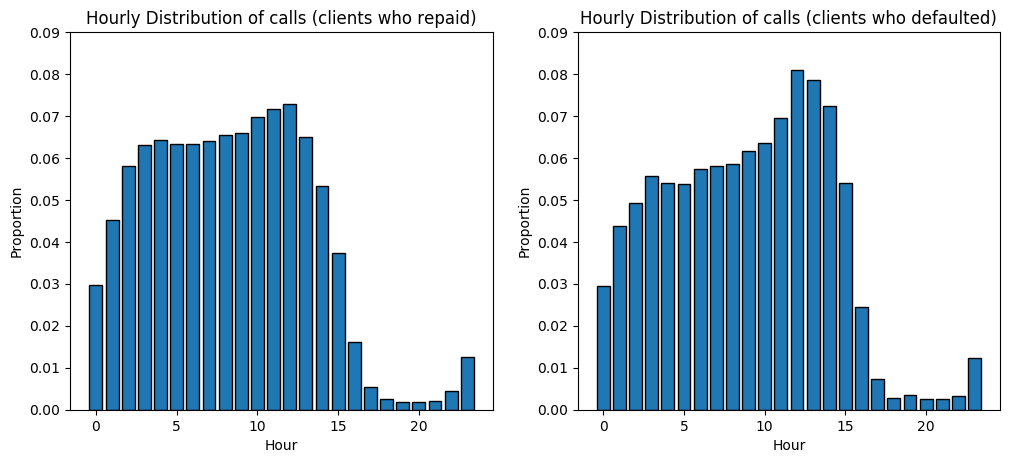

In [6]:
# look at distribution of call times between the two separate populations
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.bar(np.arange(len(bad_call_counts)), bad_call_counts, edgecolor='black')
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.ylim(0,.09)
plt.title('Hourly Distribution of calls (clients who defaulted)')
plt.subplot(1,2,1)
plt.bar(np.arange(len(good_call_counts)),good_call_counts, edgecolor='black')
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.ylim(0,.09)
plt.title('Hourly Distribution of calls (clients who repaid)')
plt.savefig('photos/hourly_dist_calls.png')
plt.show()

## Contact Lists

In [65]:
contact_df = pd.read_csv('user_contacts.csv')
group_df = pd.DataFrame(contact_df.groupby(by='user_id')['dev_id'].count()).reset_index()
group_df = group_df.merge(status_df,on="user_id")
group_df = group_df.rename(columns={'dev_id':'contact_count'})

In [66]:
print sp.pearsonr(group_df['contact_count'], group_df['status'])

(0.11745856204629351, 0.018775460081159313)


In [67]:
sub4 = group_df[group_df['contact_count'] < 350]
sub5 = group_df[group_df['contact_count'] >= 350]
print 'reimbursement rate (< 350 contacts):', sum(sub4['status'])/float(len(sub4)), len(sub4)
print 'reimbursement rate (>= 350 contacts): ', sum(sub5['status'])/float(len(sub5)), len(sub5)

reimbursement rate (< 350 contacts): 0.433497536946 203
reimbursement rate (>= 350 contacts):  0.568527918782 197


## SMS Logs

In [83]:
# explore sms_df
sms_df = pd.read_csv('user_sms.csv')
sms_df['message_body'] = sms_df['message_body'].replace(np.nan, '', regex=True)
bank_df = sms_df[(sms_df['sms_address']=='Safaricom') | (sms_df['sms_address']=='MPESA') | \
                 (sms_df['sms_address']=='SAFARICOM')]
bank_df['confirmed'] = ['onfirmed' in s for s in bank_df['message_body']]
bank_df['failed'] = [s[:4]== "Fail" for s in bank_df['message_body']]
bank_df['Nyongeza imefaulu'] = ['Nyongeza imefaulu' in s for s in bank_df['message_body']]
bank_df['awarded'] = ['awarded' in s for s in bank_df['message_body']]


# calculate call count, average duration
group_df = bank_df.groupby(by=['user_id'])['message_len'].agg({'count': len, 'avg_len': np.mean})
group_df = pd.DataFrame(group_df)
group_df.insert(0, 'user_id', group_df.index)
group_df = group_df.merge(status_df, on=['user_id'])
sms_types = bank_df.groupby(by=['user_id'])['confirmed', 'failed','Nyongeza imefaulu','awarded'\
                                           ].sum().reset_index() # count confirmaion/failed sms
group_df = group_df.merge(sms_types, on=['user_id'])

In [81]:
sub1 = group_df[group_df['count']<200]
sub2 = group_df[group_df['count']>=200]
print np.mean(sub1['status']), len(sub1), np.mean(sub2['status']), len(sub2)

0.3 200 0.710659898477 197


In [85]:
# clear positive association between number of bank texts and loan status
print sp.pearsonr(group_df['count'], group_df['status'])

# similar association with average length
print sp.pearsonr(group_df['avg_len'], group_df['status'])

print sp.pearsonr(group_df['confirmed'], group_df['status'])

print sp.pearsonr(group_df['failed'], group_df['status'])

(0.33183641841304395, 1.1679207923358952e-11)
(0.23924509152557366, 1.4205525587230382e-06)
(0.35361277459884743, 3.890159394259006e-13)
(0.27277262744303005, 3.3345650862694594e-08)


In [87]:
sum(group_df['failed']), sum(group_df['confirmed']),sum(group_df['Nyongeza imefaulu']), sum(group_df['awarded'])

(2888.0, 71370.0, 917.0, 958.0)

## Number of Devices

In [122]:
# calculate call count, average duration
group_df = call_df.groupby(by=['user_id'])['device_count'].agg({'device_count': np.mean})
group_df = pd.DataFrame(group_df)
group_df.insert(0, 'user_id', group_df.index)
group_df = group_df.merge(status_df, on=['user_id'])

In [123]:
sub1 = group_df[group_df['device_count'] == 1]
sub2 = group_df[group_df['device_count'] == 2]
sub3 = group_df[group_df['device_count'] >= 3]

print 'reimbursement rate (1 device):', sum(sub1['status'])/float(len(sub1))
print 'reimbursement rate (2 devices): ', sum(sub2['status'])/float(len(sub2))
print 'reimbursement rate (3+ devices): ', sum(sub3['status'])/float(len(sub3))

reimbursement rate (1 device): 0.474474474474
reimbursement rate (2 devices):  0.583333333333
reimbursement rate (3+ devices):  0.736842105263


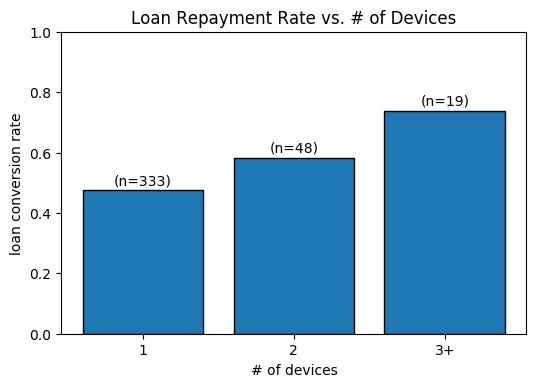

In [124]:
# bar graph with listed counts for each number
sub_dfs = [sub1, sub2, sub3]
levels = [sum(sub['status'])/float(len(sub)) for sub in sub_dfs]
x = np.arange(1, len(levels)+1)
ticks = ('1', '2', '3+')
plt.xticks(x, ticks)
bar_plot = plt.bar(x,levels, edgecolor='black')
plt.xlabel('# of devices')
plt.ylabel('loan conversion rate')
plt.ylim(0,1)
for i,rect in enumerate(bar_plot):
    height = rect.get_height() + .01
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '(n='+str(len(sub_dfs[i]))+')', ha='center', va='bottom')

plt.title('Loan Repayment Rate vs. # of Devices')
plt.savefig('photos/num_devices.png')
plt.show()

In [125]:
print sp.pearsonr(group_df['device_count'], group_df['status'])

(0.13934998518056535, 0.0052397631170810911)


In [ ]:
# # visualize distribution of calls across hours 0-23 among each subpopulation (weighting each user equally)
# good_df = call_df[call_df['status']]
# bad_df = call_df[~call_df['status']]

# good_df = good_df.pivot_table(index='hour', 
#                      columns='user_id', 
#                      values='call_type',
#                      fill_value=0, 
#                      aggfunc='count').unstack().to_frame().rename(columns={0:'call_count'}).reset_index()

# call_counts = good_df.groupby(by=['user_id'])['call_count'].sum()
# good_df['call_count'] = [float(row['call_count'])/call_counts[row['user_id']] for i, row in good_df.iterrows()]
# good_df = good_df.groupby(by='hour')['call_count'].mean()

# bad_df = bad_df.pivot_table(index='hour', 
#                      columns='user_id', 
#                      values='call_type',
#                      fill_value=0, 
#                      aggfunc='count').unstack().to_frame().rename(columns={0:'call_count'}).reset_index()

# call_counts = bad_df.groupby(by=['user_id'])['call_count'].sum()
# bad_df['call_count'] = [float(row['call_count'])/call_counts[row['user_id']] for i, row in bad_df.iterrows()]
# bad_df = bad_df.groupby(by='hour')['call_count'].mean()

In [16]:
# sub1 = group_df[group_df['contact_count'] < 250]
# sub2 = group_df[(group_df['contact_count'] >= 250) & (group_df['contact_count'] < 500)]
# sub3 = group_df[group_df['contact_count'] >= 500]

# print 'reimbursement rate (< 250 contacts):', sum(sub1['status'])/float(len(sub1)), len(sub1)
# print 'reimbursement rate (250 <= x < 500 contacts): ', sum(sub2['status'])/float(len(sub2)), len(sub2)
# print 'reimbursement rate (>= 500 contacts): ', sum(sub3['status'])/float(len(sub3)), len(sub3)

In [ ]:
# adds = [s for s in sms_df['sms_address'] if s==s and type(s) != float]
# adds = [s for s in adds if s[0] not in ('+','0','2','1','3','4','5','6','7','8','9')]
# adds = list(set(adds))
# add_counts = [np.sum(sms_df['sms_address']==add) for add in adds]
# add_c = zip(adds, add_counts)
# # sorted(add_c, key=lambda x:x[1])[::-1]

In [ ]:
# try tokenizing, with splits on " " "." ","
# then find the single words most highly correlated to bad users
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.cluster import KMeans

# vec = CountVectorizer()
# X = vec.fit_transform(sms_df['message_body'])

# # to do: perform a clustering analysis of messages...
# # identify messages associated with repayment...
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans

# # vectorizer = TfidfVectorizer(stop_words='english')
# # X = vectorizer.fit_transform(documents)